<a href="https://colab.research.google.com/github/cmd-gunma-univ/DX-highschool/blob/main/YOLO%E7%B7%B4%E7%BF%922(pose).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

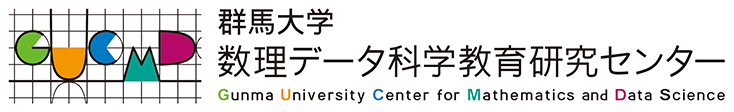

本デジタル教材の著作権は群馬大学数理データ科学教育研究センターに帰属します。

群馬大学出版会

Gunma University Press

TEL: 027-220-7180

# YOLOの使い方練習2

In [ ]:
# ポーズ
from IPython.display import Video

Video("Videos/pose.mp4", width=320)

In [ ]:
# 挙手
from IPython.display import Video

Video("Videos/raisehand.mp4", width=320)

In [ ]:
# スクワット
from IPython.display import Video

Video("Videos/squat.mp4", width=320)

---
## ポーズ検出(yolov8n-pose.ptを使う)
### 人のポーズを計測

In [ ]:
from ultralytics import YOLO
import cv2, time
from IPython.display import display, Image, clear_output
import numpy as np

# ===== 検出専用モデル =====
model = YOLO("yolov8n.pt")   # ← ここを変更（高速）

video_path = "Videos/pose.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("動画が開けませんでした。")

# ===== 高速化パラメータ =====
RESIZE_W = 320
CONF = 0.35
INFER_EVERY = 3
DISPLAY_EVERY = 3

frame_i = 0
last_annotated = None

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("動画終了")
            break

        frame_i += 1

        # ===== 解像度を下げる =====
        h, w = frame.shape[:2]
        scale = RESIZE_W / w
        frame_small = cv2.resize(frame, (RESIZE_W, int(h * scale)))

        if frame_i % INFER_EVERY == 0:

            # ===== personのみ検出 =====
            results = model.predict(
                source=frame_small,
                imgsz=RESIZE_W,
                conf=CONF,
                classes=[0],   # ← personだけ（高速）
                verbose=False
            )[0]

            annotated = frame_small.copy()

            # ===== 最大bboxの1人だけ =====
            if results.boxes is not None and len(results.boxes) > 0:

                boxes = results.boxes.xyxy.cpu().numpy()
                confs = results.boxes.conf.cpu().numpy()

                # 面積最大の人物
                areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
                idx = np.argmax(areas)

                x1, y1, x2, y2 = boxes[idx].astype(int)
                conf = confs[idx]

                # bbox描画
                cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # ラベル
                cv2.putText(
                    annotated,
                    f"person {conf:.2f}",
                    (x1, max(0, y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (0, 255, 0),
                    2
                )

            last_annotated = annotated

        else:
            if last_annotated is None:
                last_annotated = frame_small

        # ===== 表示 =====
        if frame_i % DISPLAY_EVERY == 0:
            ok, jpg = cv2.imencode(".jpg", last_annotated)
            if ok:
                clear_output(wait=True)
                display(Image(data=jpg.tobytes()))

except KeyboardInterrupt:
    print("⏹ 停止")

finally:
    cap.release()
    print("完了")

In [ ]:
from ultralytics import YOLO
import cv2, time
from IPython.display import display, Image, clear_output
import numpy as np

model = YOLO("yolov8n-pose.pt")

video_path = "Videos/pose.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("動画が開けませんでした。パスを確認してください。")

# ===== 調整パラメータ =====
RESIZE_W = 320
CONF = 0.35
INFER_EVERY = 3
DISPLAY_EVERY = 3
SLEEP = 0.0

frame_i = 0
last_annotated = None

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("動画終了")
            break

        frame_i += 1

        # 解像度を下げる
        h, w = frame.shape[:2]
        scale = RESIZE_W / w
        frame_small = cv2.resize(frame, (RESIZE_W, int(h * scale)))

        if frame_i % INFER_EVERY == 0:
            results = model.predict(
                source=frame_small,
                imgsz=RESIZE_W,
                conf=CONF,
                verbose=False
            )[0]

            # ===== ここが重要（1人だけ）=====
            if results.boxes is not None and len(results.boxes) > 0:

                boxes = results.boxes.xyxy.cpu().numpy()

                # bbox 面積
                areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
                idx = np.argmax(areas)  # 最大の人

                # 1人だけに絞る
                results.boxes = results.boxes[idx:idx+1]

                # pose も同じindexで絞る
                if results.keypoints is not None:
                    results.keypoints = results.keypoints[idx:idx+1]

            # 描画
            last_annotated = results.plot()

        else:
            if last_annotated is None:
                last_annotated = frame_small

        if frame_i % DISPLAY_EVERY == 0:
            ok, jpg = cv2.imencode(".jpg", last_annotated, [int(cv2.IMWRITE_JPEG_QUALITY), 70])
            if ok:
                clear_output(wait=True)
                display(Image(data=jpg.tobytes()))

        if SLEEP > 0:
            time.sleep(SLEEP)

except KeyboardInterrupt:
    print("⏹ 停止")

finally:
    cap.release()
    print("完了")

### YOLO Pose（COCO 17 keypoints）

| No | Body part | 日本語 |
|:--:|:--|:--|
| 0 | nose | 鼻 |
| 1 | left_eye | 左目 |
| 2 | right_eye | 右目 |
| 3 | left_ear | 左耳 |
| 4 | right_ear | 右耳 |
| 5 | left_shoulder | 左肩 |
| 6 | right_shoulder | 右肩 |
| 7 | left_elbow | 左ひじ |
| 8 | right_elbow | 右ひじ |
| 9 | left_wrist | 左手首 |
| 10 | right_wrist | 右手首 |
| 11 | left_hip | 左腰 |
| 12 | right_hip | 右腰 |
| 13 | left_knee | 左ひざ |
| 14 | right_knee | 右ひざ |
| 15 | left_ankle | 左足首 |
| 16 | right_ankle | 右足首 |

---
## 挙手を判定するには？

In [ ]:
from ultralytics import YOLO
import cv2, time
from IPython.display import display, Image, clear_output
import numpy as np

model = YOLO("yolov8n-pose.pt")

video_path = "Videos/raisehand.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("動画が開けませんでした。パスを確認してください。")

# ===== 調整パラメータ =====
RESIZE_W = 320
CONF = 0.35
INFER_EVERY = 3
DISPLAY_EVERY = 3
SLEEP = 0.0

# ===== 挙手判定パラメータ =====
KP_CONF_TH = 0.25   # キーポイント信頼度の閾値（低い点を無視）

# COCO keypoints index
L_SHOULDER, R_SHOULDER = 5, 6
L_WRIST,    R_WRIST    = 9, 10

def is_hand_raised_one_person(kxy, kconf):
    """
    kxy: (17,2)  keypoints xy
    kconf: (17,) keypoints confidence
    return: True/False
    """
    def valid(i):
        return (kconf is None) or (kconf[i] >= KP_CONF_TH)

    raised = False

    # 左手: 左手首が左肩より上
    if kxy[L_WRIST, 1] < kxy[L_SHOULDER, 1]:
        raised = True

    # 右手: 右手首が右肩より上
    if kxy[R_WRIST, 1] < kxy[R_SHOULDER, 1]:
        raised = True

    return raised

frame_i = 0
last_annotated = None
last_flag = None

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("動画終了")
            break

        frame_i += 1

        # 解像度を下げる（縦横比維持）
        h, w = frame.shape[:2]
        scale = RESIZE_W / w
        frame_small = cv2.resize(frame, (RESIZE_W, int(h * scale)))

        # 推論は間引き
        if frame_i % INFER_EVERY == 0:
            results = model.predict(
                source=frame_small,
                imgsz=RESIZE_W,
                conf=CONF,
                verbose=False
            )[0]

            # 骨格描画フレーム
            annotated = results.plot()

            # ===== 挙手判定 =====
            raised_any = False
            if results.keypoints is not None and len(results.keypoints) > 0:
                # xy: (N,17,2), conf: (N,17)
                kxy_all = results.keypoints.xy.cpu().numpy()
                # conf が取れない環境もあるので安全に
                kconf_all = None
                if hasattr(results.keypoints, "conf") and results.keypoints.conf is not None:
                    kconf_all = results.keypoints.conf.cpu().numpy()

                for i in range(kxy_all.shape[0]):
                    kxy = kxy_all[i]
                    kconf = kconf_all[i] if kconf_all is not None else None
                    if is_hand_raised_one_person(kxy, kconf):
                        raised_any = True
                        break

            last_flag = raised_any

            # ===== 文字を描画 =====
            text = "RAISED" if raised_any else "NOT RAISED"
            cv2.putText(
                annotated,
                text,
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.0,
                (0, 255, 0) if raised_any else (0, 0, 255),
                2,
                cv2.LINE_AA
            )

            last_annotated = annotated

        else:
            if last_annotated is None:
                last_annotated = frame_small

        # 表示も間引き（Jupyterが重いので効く）
        if frame_i % DISPLAY_EVERY == 0:
            ok, jpg = cv2.imencode(".jpg", last_annotated, [int(cv2.IMWRITE_JPEG_QUALITY), 70])
            if ok:
                clear_output(wait=True)
                display(Image(data=jpg.tobytes()))

        if SLEEP > 0:
            time.sleep(SLEEP)

except KeyboardInterrupt:
    print("⏹ 停止")

finally:
    cap.release()
    print("完了")

## 練習問題2-1
背伸びと挙手を区別し、挙手した時だけ、"RAISED"が表示されるようにコードを修正しなさい

## 練習問題2-2
スクワットの動画について、膝の角度変化をグラフにして回数を測定するコードを書きなさい。

[解答例](https://github.com/cmd-gunma-univ/DX-highschool/blob/main/yolo_ex/ex.squat_knee-angle.py)

## 練習問題2-3
USBカメラでポーズ検出を行い、右手を挙げたらright_hand.jpgとして写真撮影を行い停止するコードを書きなさい。

[解答例](https://github.com/cmd-gunma-univ/DX-highschool/blob/main/yolo_ex/ex.right_hand-capture.py)